In [37]:
import sys,os,os.path
sys.path.append("../../") # if you move files around, you need to adjust this!
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun

from IC.invisible_cities.evm.event_model                          import HitCollection

from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType

from IC.invisible_cities.reco import hits_functions as hif

from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio

from collections import defaultdict

import matplotlib.cm as cm
from matplotlib.colors import Normalize



In [38]:
print(np.__version__)

1.20.3


In [39]:


def threshold_hits(threshold_charge, same_peak, hitc):
    """
    Applies a threshold to hits and redistributes the charge/energy.

    Parameters
    ----------
    threshold_charge : float
        minimum pes of a hit
    same_peak        : bool
        whether to reassign NN hits' energy only to the hits from the same peak

    Returns
    ----------
    A function that takes HitCollection as input and returns another object with
    only non NN hits of charge above threshold_charge.
    The energy of NN hits is redistributed among neighbors.
    """

    t = hitc.time
    thr_hits = hif.threshold_hits(hitc.hits, threshold_charge     )
    mrg_hits = hif.merge_NN_hits ( thr_hits, same_peak = same_peak)

    cor_hits = []
    for hit in mrg_hits:
        cluster = Cluster(hit.Q, xy(hit.X, hit.Y), hit.var, hit.nsipm)
        xypos   = xy(hit.Xpeak, hit.Ypeak)
        hit     = Hit(hit.npeak, cluster, hit.Z, hit.E, xypos, hit.Ec)
        cor_hits.append(hit)

    new_hitc      = HitCollection(hitc.event, t)
    new_hitc.hits = cor_hits
    return new_hitc





def hits_from_df (dst, skip_NN = False):
    """
    Function that transforms pandas DataFrame dst to HitCollection
    ------
    Parameters
    ------
    dst : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
        If time, nsipm, Xrms, Yrms, Qc, Ec, track_id are not
        inside dst the default value is set to -1
        If Xpeak, Ypeak not in dst the default value is -1000
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    https://github.com/next-exp/IC/blob/v2-development/invisible_cities/io/hits_io.py#L16
    """
    all_events = {}
    times = getattr(dst, 'time', [-1]*len(dst))
    for (event, time) , df in dst.groupby(['event', times]):
        #pandas is not consistent with numpy dtypes so we have to change it by hand
        event = np.int32(event)
        hits  = []
        for i, row in df.iterrows():
            Q = getattr(row,'Q', row.E)
            if skip_NN and Q == NN:
                continue
            if hasattr(row, 'Xrms'):
                Xrms  = row.Xrms
                Xrms2 = Xrms**2
            else:
                Xrms = Xrms2 = -1
            if hasattr(row, 'Yrms'):
                Yrms  = row.Yrms
                Yrms2 = Yrms**2
            else:
                Yrms = Yrms2 = -1
            nsipm   = getattr(row, 'nsipm'   , -1   )     # for backwards compatibility
            Qc      = getattr(row, 'Qc'      , -1   )     # for backwards compatibility
            Xpeak   = getattr(row, 'Xpeak'   , -1000)     # for backwards compatibility
            Ypeak   = getattr(row, 'Ypeak'   , -1000)     # for backwards compatibility
            Ec      = getattr(row, 'Ec'      , -1   )     # for backwards compatibility
            trackID = getattr(row, 'track_id', -1   )     # for backwards compatibility
            Ep      = getattr(row, "Ep"      , -1   )     # for backwards compatibility

            hit = Hit(row.npeak            ,
                      Cluster(Q               ,
                              xy(row.X, row.Y),
                              xy(Xrms2, Yrms2),
                              nsipm = nsipm   ,
                              z     = row.Z   ,
                              E     = row.E   ,
                              Qc    = Qc      ),
                      row.Z                ,
                      row.E                ,
                      xy(Xpeak, Ypeak)     ,
                      s2_energy_c = Ec     ,
                      track_id    = trackID,
                      Ep          = Ep     )

            hits.append(hit)

        if len(hits):
            all_events[event] = HitCollection(event, time, hits=hits)

    return all_events

def hitc_to_df_(hitc):
    columns = defaultdict(list)
    for hit in hitc.hits:
        columns["event"   ].append(hitc.event)
        columns["time"    ].append(hitc.time)
        columns["npeak"   ].append(hit .npeak)
        columns["Xpeak"   ].append(hit .Xpeak)
        columns["Ypeak"   ].append(hit .Ypeak)
        columns["nsipm"   ].append(hit .nsipm)
        columns["X"       ].append(hit .X)
        columns["Y"       ].append(hit .Y)
        columns["Xrms"    ].append(hit .Xrms)
        columns["Yrms"    ].append(hit .Yrms)
        columns["Z"       ].append(hit .Z)
        columns["Q"       ].append(hit .Q)
        columns["E"       ].append(hit .E)
        columns["Qc"      ].append(hit .Qc)
        columns["Ec"      ].append(hit .Ec)
        columns["track_id"].append(hit .track_id)
        columns["Ep"      ].append(hit .Ep)
    return pd.DataFrame(columns)



### lets try and load the sophronia stuff here

In [40]:
# loading sophronia file
soph_file = f'../LPR/208Tl/PORT_1a/prod/sophronia/sophronia_53_208Tl.h5'
soph_hdst = dstio.load_dst(soph_file, 'RECO', 'Events')#CHITS/lowTh
display(soph_hdst)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,1040000,1.040001e+12,0,-44.734885,294.925222,1,-54.425,272.125,0.0,0.0,468.859680,5.333333,1492.109253,-1.0,0.004769,-1,-1.0
1,1040000,1.040001e+12,0,-44.734885,294.925222,1,-38.875,272.125,0.0,0.0,468.859680,5.275362,1475.890667,-1.0,0.004725,-1,-1.0
2,1040000,1.040001e+12,0,-44.734885,294.925222,1,-54.425,272.125,0.0,0.0,469.894379,7.884058,612.000000,-1.0,0.001956,-1,-1.0
3,1040000,1.040001e+12,0,-44.734885,294.925222,1,-54.425,287.675,0.0,0.0,469.894379,6.550725,508.500000,-1.0,0.001628,-1,-1.0
4,1040000,1.040001e+12,0,-44.734885,294.925222,1,-38.875,272.125,0.0,0.0,469.894379,7.304348,567.000000,-1.0,0.001815,-1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179995,1040704,1.040705e+12,0,227.394810,355.749377,1,287.675,396.525,0.0,0.0,476.169891,6.724638,366.603790,-1.0,0.002122,-1,-1.0
179996,1040704,1.040705e+12,0,227.394810,355.749377,1,287.675,380.975,0.0,0.0,477.204102,8.057971,614.555115,-1.0,0.003558,-1,-1.0
179997,1040704,1.040705e+12,0,227.394810,355.749377,1,287.675,396.525,0.0,0.0,477.204102,6.666667,508.444855,-1.0,0.002944,-1,-1.0
179998,1040704,1.040705e+12,0,227.394810,355.749377,1,287.675,396.525,0.0,0.0,478.236267,5.739130,931.000000,-1.0,0.005392,-1,-1.0


### And convert to the lowTh files

In [41]:
def soph_to_lowTh(df, threshold = 5):
    '''
    Converts sophronia 'RECO/Events' to lowTh events via a rather convoluted process

    ------
    Parameters
    ------
    df : pd.DataFrame
        DataFrame with obligatory columns :
                event, npeak, X, Y, Z,  Q, E
    threshold: int
        value at which the threshold is set.
    ------
    Returns
    ------
    Dictionary {event_number : HitCollection}
    from here
    '''

    # safety check, to ensure you don't accidentally make a repeating dataframe
    


    # new parameters for threshold, this is silly but I'm copying previous convention
    pes = 1
    threshold = threshold * pes
    same_peak = True

    # convert sophronia RECO/Events to hit collection
    soph_hitc = hits_from_df(df)

    # collect the keys as the event numbers
    soph_hitc_list = list(soph_hitc.keys())

    print("Processing data...")
    # loop over all of these events
    j = 0
    for i in soph_hitc_list:
        j += 1

        if (len(soph_hitc_list)%j == 50): 
            print("{}/{}".format(j, len(soph_hitc_list)))
        # choose i'th event
        soph_hit_event = soph_hitc.get(i)

        # Apply threshold calculation
        soph_hitc_lowTh = threshold_hits(threshold, same_peak, soph_hit_event)

        # convert back to pandas dataframe using hitc_to_df
        soph_hdst_lowTh = hitc_to_df_(soph_hitc_lowTh)

        # check if pandas dataframe with all the events exists yet
        if 'full_soph_df' in locals() and isinstance(full_soph_df, pd.DataFrame):
            full_soph_df = pd.concat([full_soph_df, soph_hdst_lowTh])
        else:
            full_soph_df = soph_hdst_lowTh.copy(deep = True)
    
    return full_soph_df

        

### heres a demonstration of doing it with a singular event

In [42]:
# convert to hitcollection
soph_hits = hits_from_df(soph_hdst)

In [43]:
print(soph_hits.keys())
# collect keys
soph_hits_list = list(soph_hits.keys())
# choose event to look at
event = 1
event_soph_hits = soph_hits_list[event]
# show the output print from this
print("")
print(event_soph_hits)
soph_hit_event = soph_hits.get(event_soph_hits)
print(soph_hit_event)




dict_keys([1040000, 1040002, 1040004, 1040006, 1040008, 1040012, 1040014, 1040016, 1040018, 1040020, 1040022, 1040024, 1040026, 1040028, 1040030, 1040032, 1040034, 1040036, 1040038, 1040040, 1040042, 1040044, 1040046, 1040048, 1040050, 1040052, 1040054, 1040056, 1040058, 1040060, 1040062, 1040064, 1040066, 1040068, 1040070, 1040072, 1040074, 1040076, 1040078, 1040080, 1040082, 1040084, 1040086, 1040088, 1040090, 1040092, 1040094, 1040096, 1040098, 1040100, 1040102, 1040104, 1040106, 1040108, 1040110, 1040112, 1040114, 1040116, 1040118, 1040120, 1040122, 1040124, 1040126, 1040128, 1040130, 1040134, 1040136, 1040138, 1040140, 1040142, 1040144, 1040146, 1040148, 1040150, 1040152, 1040154, 1040156, 1040158, 1040160, 1040162, 1040164, 1040166, 1040168, 1040170, 1040172, 1040174, 1040176, 1040178, 1040180, 1040182, 1040184, 1040186, 1040188, 1040190, 1040192, 1040194, 1040196, 1040198, 1040200, 1040202, 1040204, 1040206, 1040208, 1040210, 1040212, 1040214, 1040216, 1040218, 1040220, 1040222,

In [44]:
# new parameters for threshold
pes = 1
threshold = 5 * pes
same_peak = True

# Apply threshold calculation
soph_hitc_lowTh = threshold_hits(threshold, same_peak, soph_hit_event)

In [45]:
# specific event, hitcollectionhit thing
display(soph_hitc_lowTh)

HitCollectionHit list:<Hit : npeak = 0.0 z = 61.5772705078125 XYpeak = -183.66873259016646, -142.3678941295392 E = 573.117849788316 Ec = 0.001728140697421279 Ep = -1 trackid = -1 cluster =< nsipm = 1.0 Q = 8.637681007385254
                    xy = xy(x=-163.275, y=-116.625) 3dHit = Hit(-163.275, -116.625, 61.5772705078125, E=573.117849788316)  > ><Hit : npeak = 0.0 z = 61.5772705078125 XYpeak = -183.66873259016646, -142.3678941295392 E = 457.7249879683962 Ec = 0.0013801927614713375 Ep = -1 trackid = -1 cluster =< nsipm = 1.0 Q = 6.898550510406494
                    xy = xy(x=-163.275, y=-101.075) 3dHit = Hit(-163.275, -101.075, 61.5772705078125, E=457.7249879683962)  > ><Hit : npeak = 0.0 z = 61.5772705078125 XYpeak = -183.66873259016646, -142.3678941295392 E = 603.8892711700089 Ec = 0.0018074394095836728 Ep = -1 trackid = -1 cluster =< nsipm = 1.0 Q = 9.101449012756348
                    xy = xy(x=-163.275, y=-85.525) 3dHit = Hit(-163.275, -85.525, 61.5772705078125, E=603.889271170

In [46]:
# convert back to pandas dataframe using hitc_to_df
soph_hdst_lowTh = hitc_to_df_(soph_hitc_lowTh)

In [47]:
display(soph_hdst_lowTh)

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,1040002,1.040002e+12,0.0,-183.668733,-142.367894,1.0,-163.275,-116.625,0.0,0.0,61.577271,8.637681,573.117850,-1,0.001728,-1,-1
1,1040002,1.040002e+12,0.0,-183.668733,-142.367894,1.0,-163.275,-101.075,0.0,0.0,61.577271,6.898551,457.724988,-1,0.001380,-1,-1
2,1040002,1.040002e+12,0.0,-183.668733,-142.367894,1.0,-163.275,-85.525,0.0,0.0,61.577271,9.101449,603.889271,-1,0.001807,-1,-1
3,1040002,1.040002e+12,0.0,-183.668733,-142.367894,1.0,-147.725,-116.625,0.0,0.0,61.577271,5.159420,342.332158,-1,0.001033,-1,-1
4,1040002,1.040002e+12,0.0,-183.668733,-142.367894,1.0,-147.725,-101.075,0.0,0.0,61.577271,13.449275,892.371410,-1,0.002693,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,1040002,1.040002e+12,0.0,-183.668733,-142.367894,1.0,-194.375,-178.825,0.0,0.0,130.626221,13.275362,618.002181,-1,0.001891,-1,-1
678,1040002,1.040002e+12,0.0,-183.668733,-142.367894,1.0,-178.825,-194.375,0.0,0.0,130.626221,36.869564,1716.372856,-1,0.005241,-1,-1
679,1040002,1.040002e+12,0.0,-183.668733,-142.367894,1.0,-178.825,-178.825,0.0,0.0,130.626221,15.826087,736.744977,-1,0.002241,-1,-1
680,1040002,1.040002e+12,0.0,-183.668733,-142.367894,1.0,-194.375,-194.375,0.0,0.0,131.644302,6.144928,667.201587,-1,0.002047,-1,-1


### so instead lets look beyond this and see if we can create the full dataframe from this

In [48]:
soph_lowTh = soph_to_lowTh(soph_hdst, threshold = 5)
display(soph_lowTh)

Processing data...
59/345
295/345


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,1040000,1.040001e+12,0.0,-44.734885,294.925222,1.0,-54.425,272.125,0.0,0.0,468.859680,5.333333,1492.109247,-1,0.004769,-1,-1
1,1040000,1.040001e+12,0.0,-44.734885,294.925222,1.0,-38.875,272.125,0.0,0.0,468.859680,5.275362,1475.890673,-1,0.004725,-1,-1
2,1040000,1.040001e+12,0.0,-44.734885,294.925222,1.0,-54.425,272.125,0.0,0.0,469.894379,7.884058,612.000014,-1,0.001956,-1,-1
3,1040000,1.040001e+12,0.0,-44.734885,294.925222,1.0,-54.425,287.675,0.0,0.0,469.894379,6.550725,508.500000,-1,0.001628,-1,-1
4,1040000,1.040001e+12,0.0,-44.734885,294.925222,1.0,-38.875,272.125,0.0,0.0,469.894379,7.304348,567.000024,-1,0.001815,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,1040704,1.040705e+12,0.0,227.394810,355.749377,1.0,287.675,396.525,0.0,0.0,476.169891,6.724638,366.603775,-1,0.002122,-1,-1
1202,1040704,1.040705e+12,0.0,227.394810,355.749377,1.0,287.675,380.975,0.0,0.0,477.204102,8.057971,614.555108,-1,0.003558,-1,-1
1203,1040704,1.040705e+12,0.0,227.394810,355.749377,1.0,287.675,396.525,0.0,0.0,477.204102,6.666667,508.444862,-1,0.002944,-1,-1
1204,1040704,1.040705e+12,0.0,227.394810,355.749377,1.0,287.675,396.525,0.0,0.0,478.236267,5.739130,931.000000,-1,0.005392,-1,-1


In [49]:
# Input file and some event IDs to look at.
dist = 12
typefile = 'esmeralda' #'esmeralda'
#file = f'/Users/halmamol/NEXT/files/NEXT100/separated/esmeralda/esmeralda_10_sep.h5'
file = f'../LPR/208Tl/PORT_2a/prod/esmeralda/esmeralda_53_208Tl.h5'
#file = f'/Users/halmamol/NEXT/files/FLEX/ELdistMask/Xe/bb0nu/{typefile}/NextFlex.bb0nu.FLEXELdist{dist}mask.0.detsim.h5'
evts = [90] #15, 30, 90
pitch = 15.55
detector_db     = 'localdb.NEXT100DB.sqlite3'
run_number      = -1

datatype = 'MC'


# Parameters involved in beersheba city and the deconvolution.

'''
## FROM OLD TESTING
deconv_params = dict(
  q_cut           = 5, #5 for 6mm  - 5 for 6mm
  drop_dist       = [16, 16],
  #psf_fname       = f'/Users/halmamol/NEXT/PSF_FLEX100_mask{dist}_lowQE.h5',     
  psf_fname       = f'../data/data/LightTables/NEXT100_PSF_kr83m.h5',     
  e_cut           = 6e-3, #15 for 6mm  - 15 for 6mm
  n_iterations    = 100, #150 for 6mm  - 150 for 6mm
  iteration_tol   = 1e-10,
  sample_width    = [15.55, 15.55],
  bin_size        = [ 1,  1],
  diffusion       = (1., 0.2),
  n_dim           = 2,
  deconv_mode     = DeconvolutionMode.joint)#,
 # energy_type     = HitEnergy.Ec,
 # cut_type        = CutType.abs,
 # inter_method    = InterpolationMethod.cubic)
'''

# new parameters for threshold
pes = 1
threshold = 5 * pes
same_peak = True

deconv_params = dict(
                  drop_dist       = [16., 16.],
                  psf_fname       = f'../LPR//LightTables/NEXT100_PSF_kr83m_5bar.h5',
                  q_cut           = 10,                   # WE HAVE MANUALLY CHANGED THIS FROM 10 -> 5 HERE
                  e_cut           = 12e-3,                # WE HAVE MANUALLY CHANGED THIS FROM 12e-3 TO 6e-3
                  n_iterations    = 100,
                  iteration_tol   = 1e-10,
                  sample_width    = [15.55, 15.55],
                  bin_size        = [ 1.,  1.],
                  energy_type     = HitEnergy.Ec,               #Removing these variables because they were previously? 
                  diffusion       = (1., 0.2),
                  deconv_mode     = DeconvolutionMode.joint,
                  n_dim           = 2,
                  cut_type        = CutType.abs,              #Removing these variables because they were previously?
                  inter_method    = InterpolationMethod.cubic)            #Removing these variables because they were previously?  




#DeconvolutionMode
                
deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}

# Couple of functions used in beersheba.
cut_sensors       = beerfun.cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'])

In [50]:
deconv_params


{'drop_dist': [16.0, 16.0],
 'psf_fname': '../LPR//LightTables/NEXT100_PSF_kr83m_5bar.h5',
 'q_cut': 10,
 'e_cut': 0.012,
 'n_iterations': 100,
 'iteration_tol': 1e-10,
 'sample_width': [15.55, 15.55],
 'bin_size': [1.0, 1.0],
 'energy_type': <HitEnergy.Ec: 'Ec'>,
 'diffusion': (1.0, 0.2),
 'deconv_mode': <DeconvolutionMode.joint: 'joint'>,
 'n_dim': 2,
 'cut_type': <CutType.abs: 'abs'>,
 'inter_method': <InterpolationMethod.cubic: 'cubic'>}

## City Flow

#### Input SiPM Signal

SiPM signal which the city takes (esmeralda hits). 

#### this doesnt work as the esmeralda files dont have lowTh, but you've replaced them with your new soph_lowTh files!

In [51]:
#if(typefile == 'esmeralda'): hdst = dstio.load_dst(file, 'CHITS', 'lowTh')#CHITS/lowTh
#elif(typefile == 'penthesilea'): hdst = dstio.load_dst(file, 'RECO', 'Events')#CHITS/lowTh

hdst = soph_lowTh

In [52]:
print(hdst['event'].unique())

[1040000 1040002 1040004 1040006 1040008 1040012 1040014 1040016 1040018
 1040020 1040022 1040024 1040026 1040028 1040030 1040032 1040034 1040036
 1040038 1040040 1040042 1040044 1040046 1040048 1040050 1040052 1040054
 1040056 1040058 1040060 1040062 1040064 1040066 1040068 1040070 1040072
 1040074 1040076 1040078 1040080 1040082 1040084 1040086 1040088 1040090
 1040092 1040094 1040096 1040098 1040100 1040102 1040104 1040106 1040108
 1040110 1040112 1040114 1040116 1040118 1040120 1040122 1040124 1040126
 1040128 1040130 1040134 1040136 1040138 1040140 1040142 1040144 1040146
 1040148 1040150 1040152 1040154 1040156 1040158 1040160 1040162 1040164
 1040166 1040168 1040170 1040172 1040174 1040176 1040178 1040180 1040182
 1040184 1040186 1040188 1040190 1040192 1040194 1040196 1040198 1040200
 1040202 1040204 1040206 1040208 1040210 1040212 1040214 1040216 1040218
 1040220 1040222 1040224 1040226 1040228 1040230 1040232 1040234 1040236
 1040238 1040240 1040242 1040244 1040246 1040248 10

Select event that is going to be visualized:

In [90]:
evt  = hdst.event.unique()[343]
print(evt)
hits = hdst[hdst.event == evt]

1040702


In [91]:
hits.head()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,1040702,1.040703e+12,0.0,-113.640162,118.0076,1.0,-132.175,116.625,0.0,0.0,159.166443,8.811594,916.236958,-1,0.002817,-1,-1
1,1040702,1.040703e+12,0.0,-113.640162,118.0076,1.0,-116.625,101.075,0.0,0.0,159.166443,11.594203,1205.574982,-1,0.003677,-1,-1
2,1040702,1.040703e+12,0.0,-113.640162,118.0076,1.0,-116.625,116.625,0.0,0.0,159.166443,12.869565,1338.188197,-1,0.004081,-1,-1
3,1040702,1.040703e+12,0.0,-113.640162,118.0076,1.0,-132.175,101.075,0.0,0.0,160.169632,10.782609,428.933157,-1,0.001319,-1,-1
4,1040702,1.040703e+12,0.0,-113.640162,118.0076,1.0,-132.175,116.625,0.0,0.0,160.169632,16.115942,641.093624,-1,0.001971,-1,-1


Take the ranges and midpoints of the x,y,z spaces, and bin them (for sensor simulation)

In [92]:
x_range = (hits.X.max()-hits.X.min())/2.
y_range = (hits.Y.max()-hits.Y.min())/2.
z_range = (hits.Z.max()-hits.Z.min())/2.
mid_x   = (hits.X.max()+hits.X.min())/2.
mid_y   = (hits.Y.max()+hits.Y.min())/2.
mid_z   = (hits.Z.max()+hits.Z.min())/2.

print("X maximum and minimum")
print(hits.X.max(), hits.X.min())
print("")

print("Y maximum and minimum")
print(hits.Y.max(), hits.Y.min())
print("")

print("Z maximum and minimum")
print(hits.Z.max(), hits.Z.min())

xbins = int(hits.X.max()-hits.X.min())
ybins = int(hits.Y.max()-hits.Y.min())
zbins = int((hits.Z.max()-hits.Z.min())/2.)

X maximum and minimum
-85.525 -147.725

Y maximum and minimum
147.725 85.525

Z maximum and minimum
192.5714569091797 159.16644287109375


load true info for these events here to look at

In [93]:
if (datatype == 'MC'):
    evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
    true_info = mcio.load_mchits_df(soph_file).reset_index()
    true_info.event_id = true_info.event_id.map(evtmap.evt_number)
    
    
    this_evt_true_info = true_info[true_info.event_id == evt]

    xt = this_evt_true_info.x
    yt = this_evt_true_info.y
    zt = this_evt_true_info.z
    et = this_evt_true_info.energy*1000

In [94]:
display(evtmap)
print("true:")
display(true_info)
print("soph:")
display(soph_lowTh)
#true_info.head()
display(this_evt_true_info.head())



,evt_number
nexus_evt,
520000,1040000
520001,1040002
520002,1040004
520003,1040006
520004,1040008
...,...
520348,1040696
520349,1040698
520350,1040700


true:


,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,1040000,29,0,-45.110794,281.107513,471.119812,1.538788,0.000094,ACTIVE
1,1040000,34,0,-45.110779,281.107574,471.119873,1.538811,0.000034,ACTIVE
2,1040000,33,0,-45.110798,281.107513,471.119843,1.538796,0.000023,ACTIVE
3,1040000,32,0,-45.110600,281.107483,471.119873,1.538864,0.000021,ACTIVE
4,1040000,31,0,-45.110794,281.107544,471.119873,1.538807,0.000037,ACTIVE
...,...,...,...,...,...,...,...,...,...
128758,1040704,31,10,269.017731,382.450470,468.908569,0.497274,0.001622,ACTIVE
128759,1040704,31,11,269.012817,382.456787,468.908722,0.497474,0.000841,ACTIVE
128760,1040704,31,12,269.015991,382.457581,468.913788,0.497641,0.001137,ACTIVE
128761,1040704,31,13,269.016937,382.460693,468.912079,0.497762,0.001927,ACTIVE


soph:


,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,1040000,1.040001e+12,0.0,-44.734885,294.925222,1.0,-54.425,272.125,0.0,0.0,468.859680,5.333333,1492.109247,-1,0.004769,-1,-1
1,1040000,1.040001e+12,0.0,-44.734885,294.925222,1.0,-38.875,272.125,0.0,0.0,468.859680,5.275362,1475.890673,-1,0.004725,-1,-1
2,1040000,1.040001e+12,0.0,-44.734885,294.925222,1.0,-54.425,272.125,0.0,0.0,469.894379,7.884058,612.000014,-1,0.001956,-1,-1
3,1040000,1.040001e+12,0.0,-44.734885,294.925222,1.0,-54.425,287.675,0.0,0.0,469.894379,6.550725,508.500000,-1,0.001628,-1,-1
4,1040000,1.040001e+12,0.0,-44.734885,294.925222,1.0,-38.875,272.125,0.0,0.0,469.894379,7.304348,567.000024,-1,0.001815,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1201,1040704,1.040705e+12,0.0,227.394810,355.749377,1.0,287.675,396.525,0.0,0.0,476.169891,6.724638,366.603775,-1,0.002122,-1,-1
1202,1040704,1.040705e+12,0.0,227.394810,355.749377,1.0,287.675,380.975,0.0,0.0,477.204102,8.057971,614.555108,-1,0.003558,-1,-1
1203,1040704,1.040705e+12,0.0,227.394810,355.749377,1.0,287.675,396.525,0.0,0.0,477.204102,6.666667,508.444862,-1,0.002944,-1,-1
1204,1040704,1.040705e+12,0.0,227.394810,355.749377,1.0,287.675,396.525,0.0,0.0,478.236267,5.739130,931.000000,-1,0.005392,-1,-1


,event_id,particle_id,hit_id,x,y,z,time,energy,label
127818,1040702,6,0,-100.143349,132.104919,188.261993,2.195015,0.000094,ACTIVE
127819,1040702,6,1,49.767857,372.068329,423.705383,3.422828,0.000045,ACTIVE
127820,1040702,15,0,49.767937,372.068451,423.705261,3.422871,0.000046,ACTIVE
127821,1040702,14,0,49.768036,372.068298,423.705505,3.422884,0.000044,ACTIVE
127822,1040702,13,0,49.767738,372.068481,423.705414,3.422923,0.000012,ACTIVE


In [95]:
# checking the specific thallium decay
soph_file = f'../LPR/208Tl/PORT_1a/prod/sophronia/sophronia_53_208Tl.h5'
df_ps = pd.read_hdf(soph_file, 'MC/particles')
display(df_ps[df_ps.event_id == 520044].head(20))
display(evtmap[evtmap.evt_number == 1040088])

,event_id,particle_id,particle_name,primary,mother_id,initial_x,initial_y,initial_z,initial_t,final_x,...,initial_momentum_x,initial_momentum_y,initial_momentum_z,final_momentum_x,final_momentum_y,final_momentum_z,kin_energy,length,creator_proc,final_proc
3377,520044,1,Tl208,True,0,397.359161,397.400574,531.966797,0.000000,397.359161,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,none,RadioactiveDecay
3378,520044,4,e-,False,1,397.359161,397.400574,531.966797,0.001232,395.954803,...,-0.217899,-0.675525,0.099519,-0.000000,0.000000,0.000000,3.692502e-01,4.733874,RadioactiveDecay,eIoni
3379,520044,3,anti_nu_e,False,1,397.359161,397.400574,531.966797,0.001232,-3927.285889,...,-0.278897,0.780499,-0.402003,-0.278897,0.780499,-0.402003,9.211779e-01,14284.000977,RadioactiveDecay,Transportation
3380,520044,2,Pb208[3708.451],False,1,397.359161,397.400574,531.966797,0.001232,397.359161,...,0.496797,-0.104974,0.302485,0.000000,-0.000000,0.000000,9.017531e-07,0.000000,RadioactiveDecay,RadioactiveDecay
3381,520044,6,gamma,False,2,397.359161,397.400574,531.966797,0.001232,288.456940,...,-0.386133,-0.012287,0.334073,0.000000,-0.000000,0.000000,5.107393e-01,452.534485,RadioactiveDecay,phot
3382,520044,21,e-,False,6,288.456940,286.218567,602.680359,1.510725,288.456757,...,-0.004485,0.000315,0.000895,-0.000000,0.000000,0.000000,2.056000e-05,0.000310,phot,eIoni
3383,520044,20,e-,False,6,288.456940,286.218567,602.680359,1.510725,288.456848,...,-0.003607,-0.002028,-0.001973,0.000000,-0.000000,-0.000000,2.056000e-05,0.000117,phot,msc
3384,520044,19,e-,False,6,288.456940,286.218567,602.680359,1.510725,288.456390,...,-0.017797,0.008857,-0.012609,-0.000000,0.000000,-0.000000,5.419600e-04,0.002781,phot,eIoni
3385,520044,18,gamma,False,6,288.456940,286.218567,602.680359,1.510725,287.608765,...,-0.003162,0.000764,-0.002491,-0.000000,0.000000,-0.000000,4.097180e-03,1.098966,phot,phot
3386,520044,30,e-,False,18,287.608765,286.423523,602.012329,1.514391,287.608948,...,0.005763,-0.003575,-0.000938,0.000000,-0.000000,-0.000000,4.586000e-05,0.000290,phot,msc


,evt_number
nexus_evt,
520044,1040088


In [96]:
# take event number
print(this_evt_true_info['event_id'].to_numpy()[0])
no = this_evt_true_info['event_id'].to_numpy()[0]
# and file, because we know the last 9 characters are always the same, we can take the number
print(soph_file)
print(soph_file.split('sophronia_')[1].split('_208Tl')[0])
file_number = soph_file.split('sophronia_')[1].split('_208Tl')[0]
dir_name = "Th208_" + file_number + "_event_" + str(no)

pre_dir_name = 'beersheba_event_plots/'

if not os.path.isdir(pre_dir_name + dir_name):
    os.mkdir(pre_dir_name +dir_name)

1040702
../LPR/208Tl/PORT_1a/prod/sophronia/sophronia_53_208Tl.h5
53


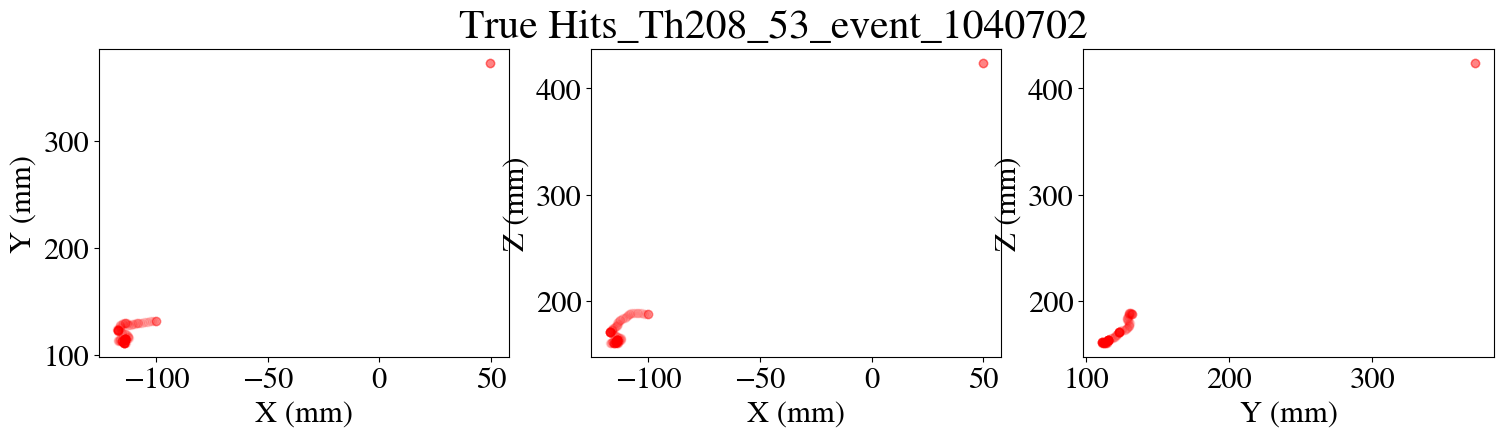

In [97]:
# true data type plots
if (datatype == 'MC'):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');

    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    
    fig.suptitle('True Hits_' + dir_name, fontsize=30)
    fig.savefig(pre_dir_name + dir_name + "/MC_hits")

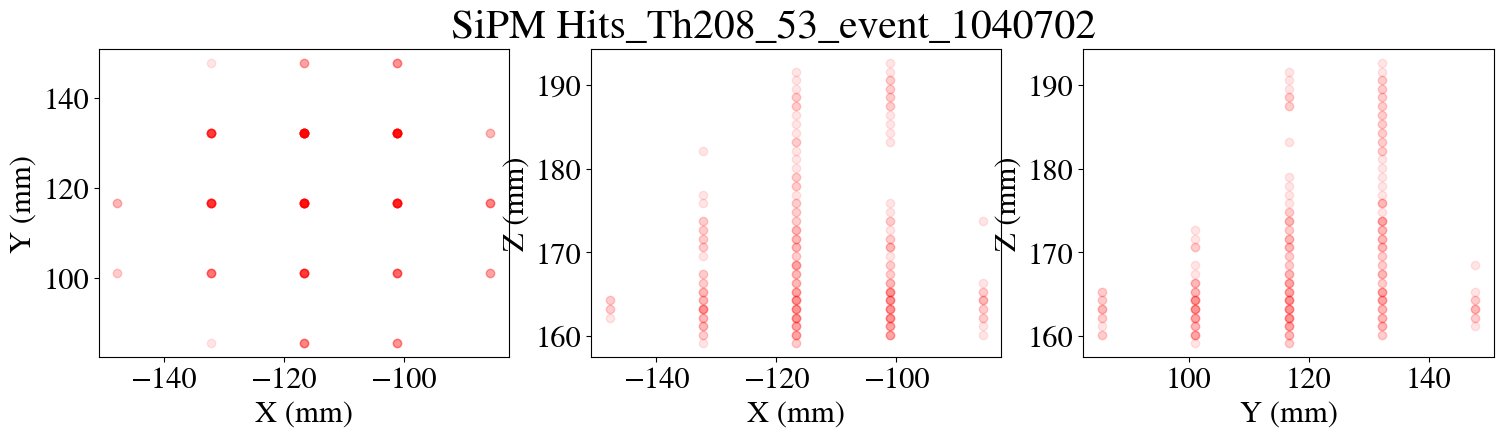

In [98]:
# plotting sipm data normally
# true data type plots

fig, axes = plt.subplots(1, 3, figsize=(18, 4))
axes[0].scatter(hits.X, hits.Y,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].scatter(hits.X, hits.Z,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].scatter(hits.Y, hits.Z,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');


fig.suptitle('SiPM Hits_' + dir_name, fontsize=30)
fig.savefig(pre_dir_name + dir_name +  "/SiPM_hits")

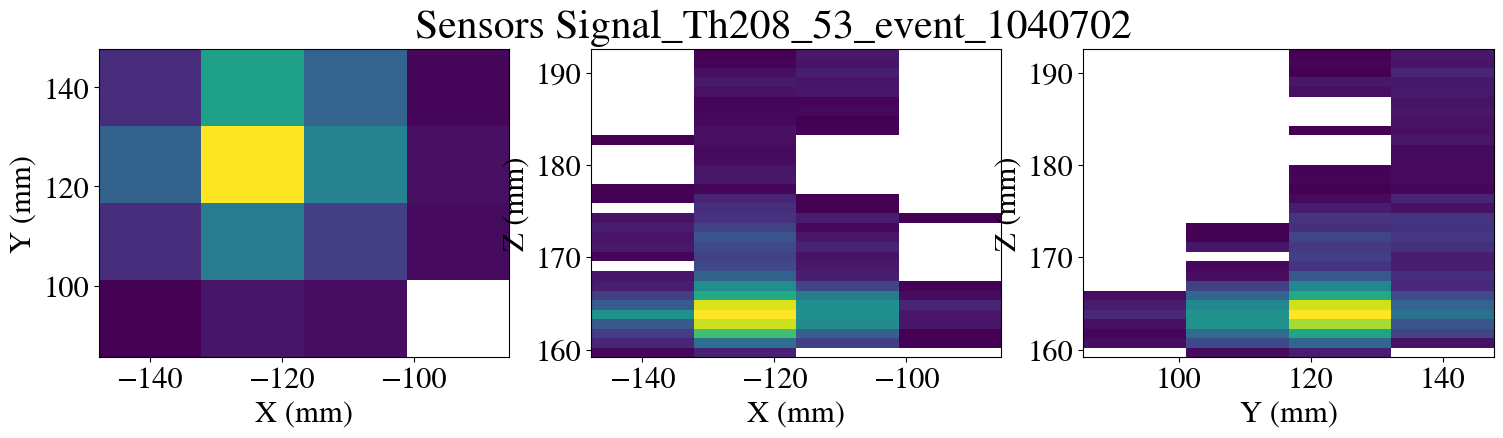

In [99]:
# then applying transformations to convert to 'SiPM outputs'
fig, axes = plt.subplots(1, 3, figsize=(18, 4))


xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('Sensors Signal_' + dir_name, fontsize=30)
fig.savefig(pre_dir_name + dir_name +  "/sensor_signal")

#### Cut sensors

 Cut sensors below a given threshold, this cleans the signal and removes hits considered not part of the image. It can be seen that the cut does not harm the image noticeably.

In [100]:
qmin = deconv_params['q_cut']
print(f'Cutting sensors below {qmin}')

Cutting sensors below 10


In [101]:
hits_cut = coref.timefunc(cut_sensors)(hits.copy())

Time spent in cut_over_Q: 0.009731769561767578 s


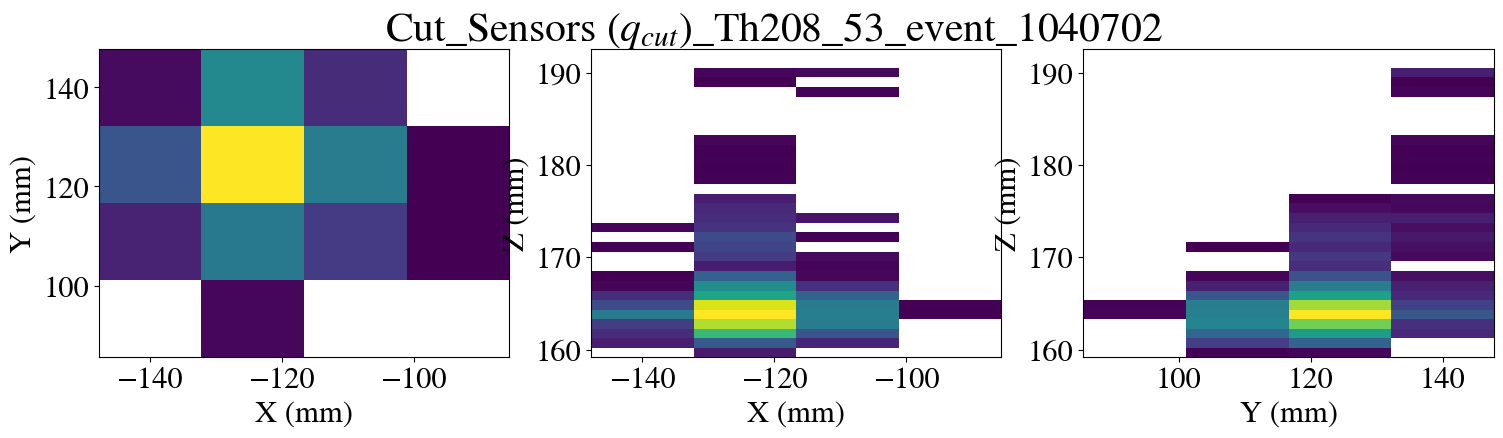

In [102]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_cut.X, hits_cut.Y, bins=[xx, yy], weights=hits_cut.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_cut.X, hits_cut.Z, bins=[xx, zz], weights=hits_cut.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_cut.Y, hits_cut.Z, bins=[yy, zz], weights=hits_cut.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');


fig.suptitle('Cut_Sensors ($q_{cut}$)_' + dir_name, fontsize=30)
fig.savefig(pre_dir_name + dir_name +  "/Cut_Sensors")

Increased cut to see the impact of the function on higher thresholds:

In [103]:
cut_sensors_high = beerfun.cut_over_Q(17, ['E', 'Ec'])
hits_cut_2       = coref.timefunc(cut_sensors_high)(hits.copy())

Time spent in cut_over_Q: 0.0102081298828125 s


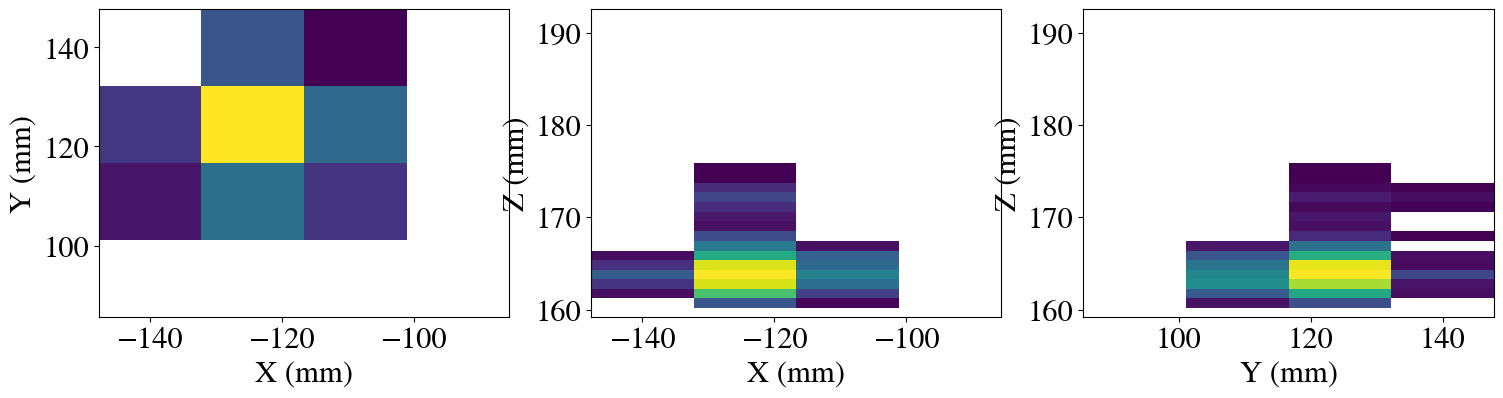

In [104]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_cut_2.X, hits_cut_2.Y, bins=[xx, yy], weights=hits_cut_2.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_cut_2.X, hits_cut_2.Z, bins=[xx, zz], weights=hits_cut_2.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_cut_2.Y, hits_cut_2.Z, bins=[yy, zz], weights=hits_cut_2.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

When cutting, the energy is distributed through the remaining hits so the total energy of the event remains the same:

In [105]:
print(f'Energy (corrected) before cuts:    {hits.E.sum()} ({hits.Ec.sum()})')
print(f'Energy (corrected) after low cut:  {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
print(f'Energy (corrected) after high cut: {hits_cut_2.E.sum()} ({hits_cut_2.Ec.sum()})')

Energy (corrected) before cuts:    131595.99684066122 (0.40309173197911585)
Energy (corrected) after low cut:  131595.9968406612 (0.40309173197911585)
Energy (corrected) after high cut: 131595.99684066116 (0.40309173197911585)


#### Drop isolated sensors

Cut sensors that are isolated in XY. Basically drops a sensor if there are no sensors near-by (distance can be configurable) that have seen light in the event.

In [106]:
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in drop_isolated: 0.006804227828979492 s


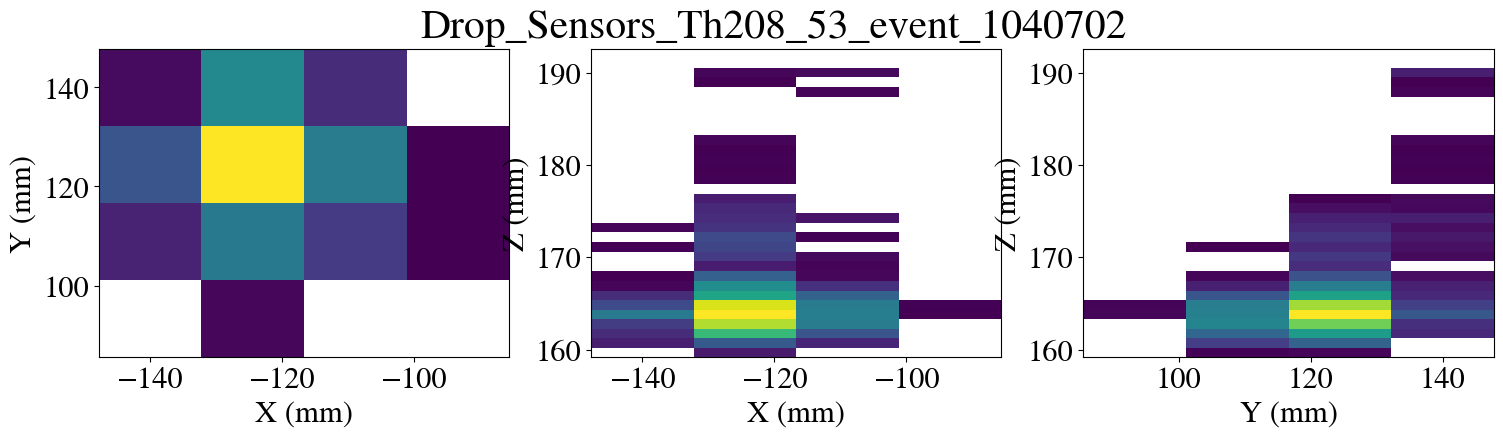

In [107]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('Drop_Sensors_' + dir_name, fontsize=30)
fig.savefig(pre_dir_name + dir_name +  "/Drop_Sensors")


It usually does not make a difference, as it's not usual to have rogue SiPMs. Let's add one and check the performance of the function:

In [108]:
hits_cut.loc[len(hits_cut)] = hits_cut.loc[0].values
hits_cut.loc[len(hits_cut)-1, ['X', 'Y', 'Q']] = [-250, -250, 1000]

In [109]:
hits_cut.tail()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
93,1040702.0,1.040703e+12,0.0,-113.640162,118.0076,1.0,-101.075,132.175,0.0,0.0,187.427032,11.942029,802.807358,-1.0,0.002478,-1.0,-1.0
94,1040702.0,1.040703e+12,0.0,-113.640162,118.0076,1.0,-116.625,132.175,0.0,0.0,188.482254,10.840580,768.112660,-1.0,0.002371,-1.0,-1.0
95,1040702.0,1.040703e+12,0.0,-113.640162,118.0076,1.0,-116.625,132.175,0.0,0.0,189.508286,13.159420,1047.005787,-1.0,0.003233,-1.0,-1.0
96,1040702.0,1.040703e+12,0.0,-113.640162,118.0076,1.0,-101.075,132.175,0.0,0.0,189.508286,14.956522,1189.989001,-1.0,0.003674,-1.0,-1.0
97,1040702.0,1.040703e+12,0.0,-113.640162,118.0076,1.0,-250.000,-250.000,0.0,0.0,159.166443,1000.000000,1629.240140,-1.0,0.004972,-1.0,-1.0


### be not afraid of these plots, notebook-wanderer. For these are purposefully crap to demonstrate how to modify the event

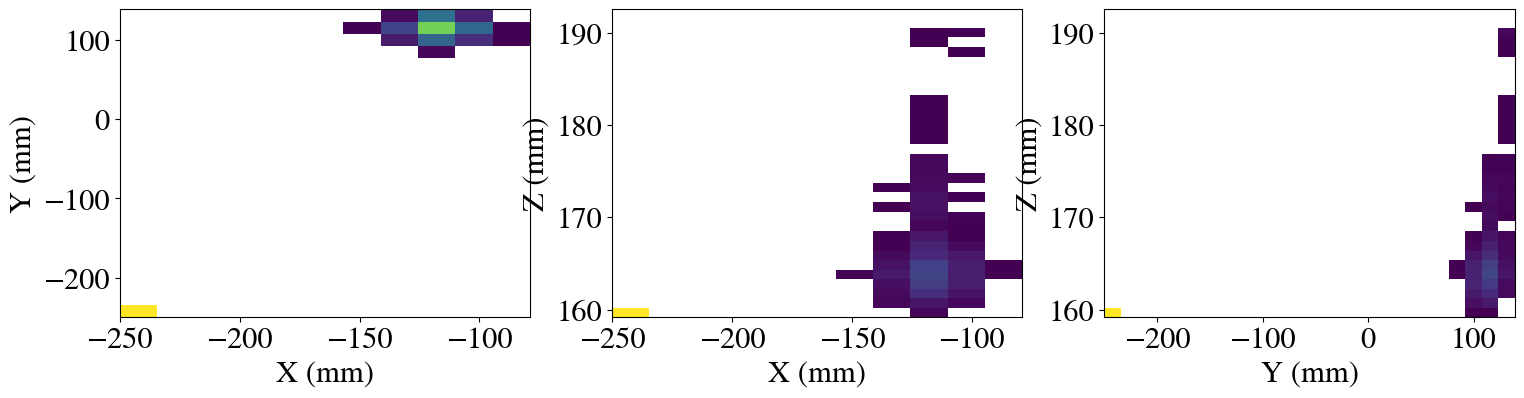

In [110]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits_cut.X.min(), hits_cut.X.max() + pitch, pitch)
yy = np.arange(hits_cut.Y.min(), hits_cut.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_cut.X, hits_cut.Y, bins=[xx, yy], weights=hits_cut.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_cut.X, hits_cut.Z, bins=[xx, zz], weights=hits_cut.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_cut.Y, hits_cut.Z, bins=[yy, zz], weights=hits_cut.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');



And now after cut:


In [111]:
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in drop_isolated: 0.006896257400512695 s


In [112]:
hits_drop.head()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,1040702.0,1.040703e+12,0.0,-113.640162,118.0076,1.0,-116.625,101.075,0.0,0.0,159.166443,11.594203,1649.411144,-1.0,0.005034,-1.0,-1.0
1,1040702.0,1.040703e+12,0.0,-113.640162,118.0076,1.0,-116.625,116.625,0.0,0.0,159.166443,12.869565,1830.846325,-1.0,0.005587,-1.0,-1.0
2,1040702.0,1.040703e+12,0.0,-113.640162,118.0076,1.0,-132.175,101.075,0.0,0.0,160.169632,10.782609,586.846226,-1.0,0.001806,-1.0,-1.0
3,1040702.0,1.040703e+12,0.0,-113.640162,118.0076,1.0,-132.175,116.625,0.0,0.0,160.169632,16.115942,877.114227,-1.0,0.002699,-1.0,-1.0
4,1040702.0,1.040703e+12,0.0,-113.640162,118.0076,1.0,-116.625,101.075,0.0,0.0,160.169632,26.028986,1416.634157,-1.0,0.004324,-1.0,-1.0


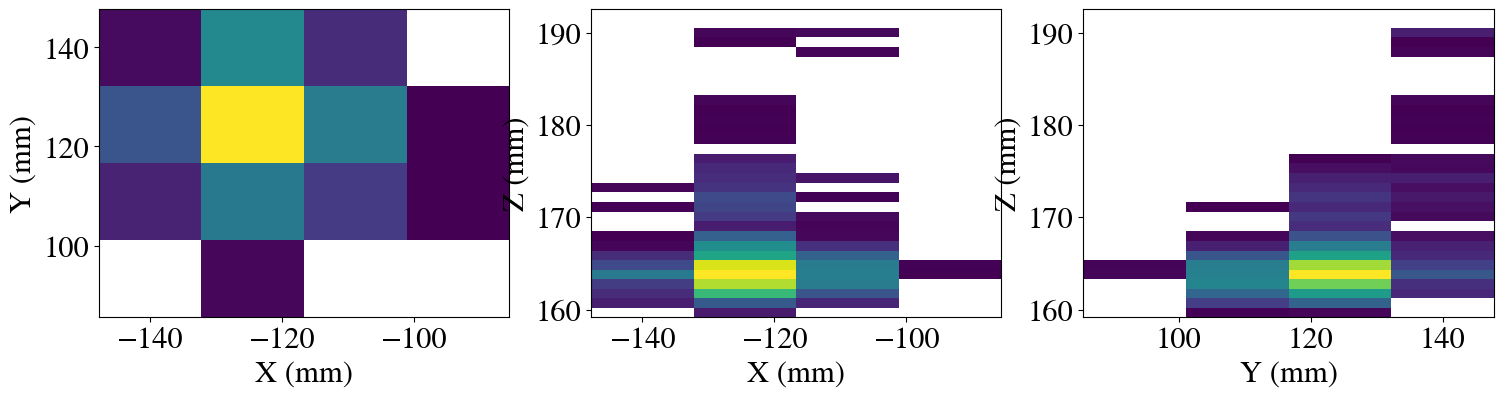

In [113]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');



When cutting, the energy is distributed through the reminding hits so the total energy of the event remains the same. The increment is due to the additional hit to hits_copy which caused an increase in the input energy. Still the energy before and after the cut remains the same as should be expected.

In [114]:
print(f'Energy (corrected) before cut: {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
print(f'Energy (corrected) after  cut: {hits_drop.E.sum()} ({hits_drop.Ec.sum()})')

Energy (corrected) before cut: 133225.2369802363 (0.40806401513096)
Energy (corrected) after  cut: 133225.23698023634 (0.40806401513096)


Recover the hits as they should (normal cuts):

In [115]:
hits_cut  = coref.timefunc(cut_sensors )(hits    .copy())
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in cut_over_Q: 0.007172107696533203 s
Time spent in drop_isolated: 0.01206350326538086 s


#### Deconvolve Signal 

Last function in the city is deconvolve_signal which basically chooses the deconvolution mode (either 2D or 3D, and joint or separate, see code description) and calls deconvolve function (once per S2 peak). Which first interpolates the signal and then deconvolves it. After all the process, deconvolve_signal assigns the energy, measured by the PMTs (corrected or not, chosen by parameter) to each deconvolved hit based on their fraction of energy of the full S2 peak.

Hereunder, deconvolve_signal output will be showed. Individual performance of each step will be looked into later in the notebook.

In [116]:
deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())

Time spent in apply_deconvolution: 1.565504550933838 s


In [117]:
# this is to stop your number of iterations vanishing because of the below function, as you're rewriting deconv_params_
if 'save_state' in locals():
    deconv_params_['n_iterations'] = save_state
else:
    # first time round, so set it
    save_state = deconv_params_['n_iterations']
print(save_state)

100


In [118]:


for iterN in np.arange(15, deconv_params_['n_iterations'], 15):
    deconv_params_['n_iterations'] = iterN
    deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
    print(f'{iterN} iterations')
    hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())

15 iterations
Time spent in apply_deconvolution: 0.48955368995666504 s
30 iterations
Time spent in apply_deconvolution: 0.6555740833282471 s
45 iterations
Time spent in apply_deconvolution: 0.85495924949646 s
60 iterations
Time spent in apply_deconvolution: 1.2404711246490479 s
75 iterations
Time spent in apply_deconvolution: 1.586258888244629 s
90 iterations
Time spent in apply_deconvolution: 1.6382355690002441 s


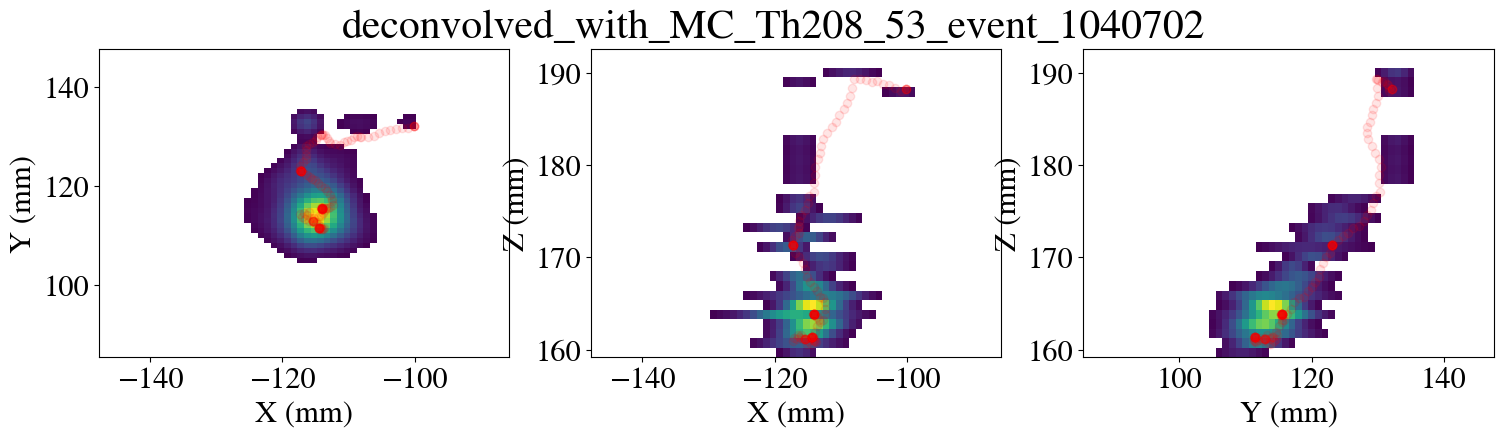

In [119]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max())
yy = np.arange(hits.Y.min(), hits.Y.max())
zz = hits.Z.unique()

axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');


fig.suptitle('deconvolved_with_MC_' + dir_name, fontsize=30)
fig.savefig(pre_dir_name + dir_name +  "/deconvolved_w_MC")

In [120]:
x = hits_deco.X
y = hits_deco.Y
z = hits_deco.Z
e = hits_deco.E*1000

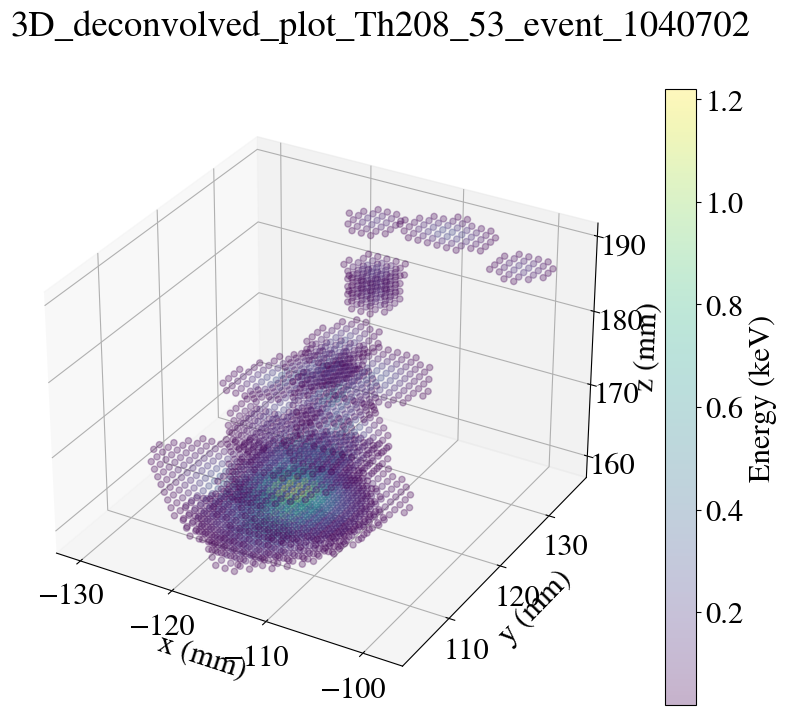

In [121]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(x, y, z, c=e, alpha=0.3, cmap='viridis')
cb = fig.colorbar(p, ax=ax)
cb.set_label('Energy (keV)')

ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_zlabel('z (mm)')

fig.suptitle('3D_deconvolved_plot_' + dir_name)
fig.savefig(pre_dir_name + dir_name +  "/3D_deconvolved_plot")

plt.show()

/tmp/ipykernel_27733/975472362.py:56: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


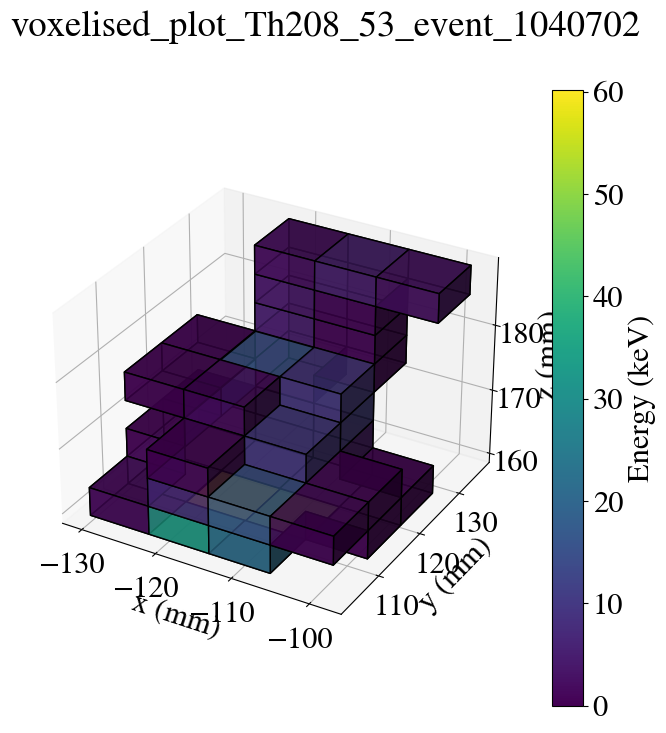

In [122]:
base_vsize = 5 #mm
the_hits = []

xs = hits_deco.X
ys = hits_deco.Y
zs = hits_deco.Z
es = hits_deco.E

for x, y, z, e in zip(xs, ys, zs, es):
    if np.isnan(e): continue
    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
    the_hits.append(h)

voxels = voxelize_hits(the_hits,
                       np.array([base_vsize*2, base_vsize*2, base_vsize]), False)

vsizex = voxels[0].size[0]
vsizey = voxels[0].size[1]
vsizez = voxels[0].size[2]

min_corner_x = min(v.X for v in voxels) - vsizex/2.
min_corner_y = min(v.Y for v in voxels) - vsizey/2.
min_corner_z = min(v.Z for v in voxels) - vsizez/2.

x = [np.round(v.X/vsizex) for v in voxels]
y = [np.round(v.Y/vsizey) for v in voxels]
z = [np.round(v.Z/vsizez) for v in voxels]
e = [v.E for v in voxels]

x_min = int(min(x))
y_min = int(min(y))
z_min = int(min(z))

x_max = int(max(x))
y_max = int(max(y))
z_max = int(max(z))

#print(f'X min = {x_min}, X max = {x_max}')
#print(f'Y min = {y_min}, Y max = {y_max}')
#print(f'Z min = {z_min}, Z max = {z_max}')

VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
#print(VOXELS.shape)

# sort through the event set the "turn on" the hit voxels
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=max(e))

colors = np.empty(VOXELS.shape, dtype=object)
for q in range(0,len(z)):
    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

# and plot everything
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
#a,b,c is spacing in mm needs an extra dim
a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
a = a*vsizex + min_corner_x
b = b*vsizey + min_corner_y
c = c*vsizez + min_corner_z

# a, b, c are the corners of the voxels
ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

ax.set_xlabel('x (mm)')#,fontsize=16)
ax.set_ylabel('y (mm)')#,fontsize=16)
ax.set_zlabel('z (mm)')#,fontsize=16)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm)
cb.set_label('Energy (keV)')

fig.suptitle('voxelised_plot_' + dir_name)
fig.savefig(pre_dir_name + dir_name +  "/voxelised_plot")

plt.show()

In [123]:
hits_deco.head()

,event,npeak,X,Y,Z,E
0,1040702,0.0,-119.325,106.675,159.166443,0.000019
1,1040702,0.0,-119.325,107.675,159.166443,0.000028
2,1040702,0.0,-119.325,108.675,159.166443,0.000034
3,1040702,0.0,-119.325,109.675,159.166443,0.000033
4,1040702,0.0,-119.325,110.675,159.166443,0.000026


In [127]:
display(hits_drop.head())
(print(hits_drop.Ec.sum()))

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,1040702,1.040703e+12,0.0,-113.640162,118.0076,1.0,-116.625,101.075,0.0,0.0,159.166443,11.594203,1629.240140,-1,0.004972,-1,-1
1,1040702,1.040703e+12,0.0,-113.640162,118.0076,1.0,-116.625,116.625,0.0,0.0,159.166443,12.869565,1808.456511,-1,0.005519,-1,-1
2,1040702,1.040703e+12,0.0,-113.640162,118.0076,1.0,-132.175,101.075,0.0,0.0,160.169632,10.782609,579.669557,-1,0.001784,-1,-1
3,1040702,1.040703e+12,0.0,-113.640162,118.0076,1.0,-132.175,116.625,0.0,0.0,160.169632,16.115942,866.387808,-1,0.002666,-1,-1
4,1040702,1.040703e+12,0.0,-113.640162,118.0076,1.0,-116.625,101.075,0.0,0.0,160.169632,26.028986,1399.309833,-1,0.004271,-1,-1


0.40309173197911585


In [128]:
display(true_info)

,event_id,particle_id,hit_id,x,y,z,time,energy,label
0,1040000,29,0,-45.110794,281.107513,471.119812,1.538788,0.000094,ACTIVE
1,1040000,34,0,-45.110779,281.107574,471.119873,1.538811,0.000034,ACTIVE
2,1040000,33,0,-45.110798,281.107513,471.119843,1.538796,0.000023,ACTIVE
3,1040000,32,0,-45.110600,281.107483,471.119873,1.538864,0.000021,ACTIVE
4,1040000,31,0,-45.110794,281.107544,471.119873,1.538807,0.000037,ACTIVE
...,...,...,...,...,...,...,...,...,...
128758,1040704,31,10,269.017731,382.450470,468.908569,0.497274,0.001622,ACTIVE
128759,1040704,31,11,269.012817,382.456787,468.908722,0.497474,0.000841,ACTIVE
128760,1040704,31,12,269.015991,382.457581,468.913788,0.497641,0.001137,ACTIVE
128761,1040704,31,13,269.016937,382.460693,468.912079,0.497762,0.001927,ACTIVE


In [86]:
break;

SyntaxError: 'break' outside loop (1693679151.py, line 1)

### Create a loop that does it all

In [ ]:
#

In [53]:
for i in range(len(hdst.event.unique())):
	evt = hdst.event.unique()[i]
	hits = hdst[hdst.event == evt]
	
	x_range = (hits.X.max()-hits.X.min())/2.
	y_range = (hits.Y.max()-hits.Y.min())/2.
	z_range = (hits.Z.max()-hits.Z.min())/2.
	mid_x   = (hits.X.max()+hits.X.min())/2.
	mid_y   = (hits.Y.max()+hits.Y.min())/2.
	mid_z   = (hits.Z.max()+hits.Z.min())/2.

	print("X maximum and minimum")
	print(hits.X.max(), hits.X.min())
	print("")

	print("Y maximum and minimum")
	print(hits.Y.max(), hits.Y.min())
	print("")

	print("Z maximum and minimum")
	print(hits.Z.max(), hits.Z.min())

	xbins = int(hits.X.max()-hits.X.min())
	ybins = int(hits.Y.max()-hits.Y.min())
	zbins = int((hits.Z.max()-hits.Z.min())/2.)
	
	
	if (datatype == 'MC'):
	    evtmap = mcio.load_eventnumbermap(soph_file).set_index('nexus_evt')
	    true_info = mcio.load_mchits_df(soph_file).reset_index()
	    true_info.event_id = true_info.event_id.map(evtmap.evt_number)
	    
	    
	    this_evt_true_info = true_info[true_info.event_id == evt]

	    xt = this_evt_true_info.x
	    yt = this_evt_true_info.y
	    zt = this_evt_true_info.z
	    et = this_evt_true_info.energy*1000
	
	no = this_evt_true_info['event_id'].to_numpy()[0]
	file_number = soph_file.split('sophronia_')[1].split('_208Tl')[0]
	dir_name = "Th208_" + file_number + "_event_" + str(no)

	pre_dir_name = 'beersheba_event_plots/'

	if not os.path.isdir(pre_dir_name + dir_name):
	    os.mkdir(pre_dir_name +dir_name)
	
	
	# true data type plots
	if (datatype == 'MC'):
	    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
	    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
	    axes[0].set_xlabel('X (mm)');
	    axes[0].set_ylabel('Y (mm)');

	    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
	    axes[1].set_xlabel('X (mm)');
	    axes[1].set_ylabel('Z (mm)');

	    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
	    axes[2].set_xlabel('Y (mm)');
	    axes[2].set_ylabel('Z (mm)');
	    
	    fig.suptitle('True Hits_' + dir_name, fontsize=30)
	    fig.savefig(pre_dir_name + dir_name + "/MC_hits")
	    plt.close()
	   
	# plotting sipm data normally
	# true data type plots

	fig, axes = plt.subplots(1, 3, figsize=(18, 4))
	axes[0].scatter(hits.X, hits.Y,  alpha=0.1, color='red')
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].scatter(hits.X, hits.Z,  alpha=0.1, color='red')
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');

	axes[2].scatter(hits.Y, hits.Z,  alpha=0.1, color='red')
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');


	fig.suptitle('SiPM Hits_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/SiPM_hits")
	plt.close()
	
	
	
	# then applying transformations to convert to 'SiPM outputs'
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))


	xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
	yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
	zz = hits.Z.unique()

	axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.0001);
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.0001);
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');


	axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.0001);
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');

	fig.suptitle('Sensors Signal_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/sensor_signal")
	plt.close()
	
	
	qmin = deconv_params['q_cut']
	print(f'Cutting sensors below {qmin}')
	
	hits_cut = coref.timefunc(cut_sensors)(hits.copy())
	
	
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))

	xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
	yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
	zz = hits.Z.unique()

	axes[0].hist2d(hits_cut.X, hits_cut.Y, bins=[xx, yy], weights=hits_cut.Q, cmin=0.0001);
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits_cut.X, hits_cut.Z, bins=[xx, zz], weights=hits_cut.Q, cmin=0.0001);
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');


	axes[2].hist2d(hits_cut.Y, hits_cut.Z, bins=[yy, zz], weights=hits_cut.Q, cmin=0.0001);
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');


	fig.suptitle('Cut_Sensors ($q_{cut}$)_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/Cut_Sensors")
	plt.close()
	
	
	cut_sensors_high = beerfun.cut_over_Q(17, ['E', 'Ec'])
	hits_cut_2       = coref.timefunc(cut_sensors_high)(hits.copy())
	
	
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))

	xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
	yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
	zz = hits.Z.unique()

	axes[0].hist2d(hits_cut_2.X, hits_cut_2.Y, bins=[xx, yy], weights=hits_cut_2.Q, cmin=0.0001);
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits_cut_2.X, hits_cut_2.Z, bins=[xx, zz], weights=hits_cut_2.Q, cmin=0.0001);
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');

	axes[2].hist2d(hits_cut_2.Y, hits_cut_2.Z, bins=[yy, zz], weights=hits_cut_2.Q, cmin=0.0001);
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');
	plt.close()
	
	
	print(f'Energy (corrected) before cuts:    {hits.E.sum()} ({hits.Ec.sum()})')
	print(f'Energy (corrected) after low cut:  {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
	print(f'Energy (corrected) after high cut: {hits_cut_2.E.sum()} ({hits_cut_2.Ec.sum()})')
	
	
	hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
	
	
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))

	xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
	yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
	zz = hits.Z.unique()

	axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');


	axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');

	fig.suptitle('Drop_Sensors_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/Drop_Sensors")
	plt.close()
	
	print(f'Energy (corrected) before cut: {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
	print(f'Energy (corrected) after  cut: {hits_drop.E.sum()} ({hits_drop.Ec.sum()})')
	
	hits_cut  = coref.timefunc(cut_sensors )(hits    .copy())
	hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())
	
	
	deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
	hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())
	
	
	# this is to stop your number of iterations vanishing because of the below function, as you're rewriting deconv_params_
	if 'save_state' in locals():
	    deconv_params_['n_iterations'] = save_state
	else:
	    # first time round, so set it
	    save_state = deconv_params_['n_iterations']
	print(save_state)
	
	
	
		
	for iterN in np.arange(15, deconv_params_['n_iterations'], 15):
	    deconv_params_['n_iterations'] = iterN
	    deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
	    print(f'{iterN} iterations')
	    hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())
	    
	    
	fig, axes = plt.subplots(1, 3, figsize=(18, 4))

	xx = np.arange(hits.X.min(), hits.X.max())
	yy = np.arange(hits.Y.min(), hits.Y.max())
	zz = hits.Z.unique()

	axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=hits_deco.E, cmin=0.0001);
	if (datatype == 'MC'):
	    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
	axes[0].set_xlabel('X (mm)');
	axes[0].set_ylabel('Y (mm)');

	axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=hits_deco.E, cmin=0.0001);
	if (datatype == 'MC'):
	    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
	axes[1].set_xlabel('X (mm)');
	axes[1].set_ylabel('Z (mm)');

	axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=hits_deco.E, cmin=0.0001);
	if (datatype == 'MC'):
	    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
	axes[2].set_xlabel('Y (mm)');
	axes[2].set_ylabel('Z (mm)');
	plt.close()


	fig.suptitle('deconvolved_with_MC_' + dir_name, fontsize=30)
	fig.savefig(pre_dir_name + dir_name +  "/deconvolved_w_MC")
	
	x = hits_deco.X
	y = hits_deco.Y
	z = hits_deco.Z
	e = hits_deco.E*1000
	
	
	fig = plt.figure()
	ax = fig.add_subplot(111, projection='3d')

	p = ax.scatter(x, y, z, c=e, alpha=0.3, cmap='viridis')
	cb = fig.colorbar(p, ax=ax)
	cb.set_label('Energy (keV)')

	ax.set_xlabel('x (mm)')
	ax.set_ylabel('y (mm)')
	ax.set_zlabel('z (mm)')

	fig.suptitle('3D_deconvolved_plot_' + dir_name)
	fig.savefig(pre_dir_name + dir_name +  "/3D_deconvolved_plot")

	plt.close()
	
	
	base_vsize = 5 #mm
	the_hits = []

	xs = hits_deco.X
	ys = hits_deco.Y
	zs = hits_deco.Z
	es = hits_deco.E

	for x, y, z, e in zip(xs, ys, zs, es):
	    if np.isnan(e): continue
	    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
	    the_hits.append(h)

	voxels = voxelize_hits(the_hits,
		               np.array([base_vsize*2, base_vsize*2, base_vsize]), False)

	vsizex = voxels[0].size[0]
	vsizey = voxels[0].size[1]
	vsizez = voxels[0].size[2]

	min_corner_x = min(v.X for v in voxels) - vsizex/2.
	min_corner_y = min(v.Y for v in voxels) - vsizey/2.
	min_corner_z = min(v.Z for v in voxels) - vsizez/2.

	x = [np.round(v.X/vsizex) for v in voxels]
	y = [np.round(v.Y/vsizey) for v in voxels]
	z = [np.round(v.Z/vsizez) for v in voxels]
	e = [v.E for v in voxels]

	x_min = int(min(x))
	y_min = int(min(y))
	z_min = int(min(z))

	x_max = int(max(x))
	y_max = int(max(y))
	z_max = int(max(z))

	#print(f'X min = {x_min}, X max = {x_max}')
	#print(f'Y min = {y_min}, Y max = {y_max}')
	#print(f'Z min = {z_min}, Z max = {z_max}')

	VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
	#print(VOXELS.shape)

	# sort through the event set the "turn on" the hit voxels
	cmap = cm.viridis
	norm = Normalize(vmin=0, vmax=max(e))

	colors = np.empty(VOXELS.shape, dtype=object)
	for q in range(0,len(z)):
	    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
	    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

	# and plot everything
	fig = plt.figure(figsize=(8,8))
	ax = fig.gca(projection='3d')
	#a,b,c is spacing in mm needs an extra dim
	a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
	a = a*vsizex + min_corner_x
	b = b*vsizey + min_corner_y
	c = c*vsizez + min_corner_z

	# a, b, c are the corners of the voxels
	ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

	ax.set_xlabel('x (mm)')#,fontsize=16)
	ax.set_ylabel('y (mm)')#,fontsize=16)
	ax.set_zlabel('z (mm)')#,fontsize=16)

	sm = cm.ScalarMappable(cmap=cmap, norm=norm)
	sm.set_array([])
	cb = fig.colorbar(sm)
	cb.set_label('Energy (keV)')

	fig.suptitle('voxelised_plot_' + dir_name)
	fig.savefig(pre_dir_name + dir_name +  "/voxelised_plot")

	plt.close()

X maximum and minimum
7.775 -85.525

Y maximum and minimum
349.875 241.025

Z maximum and minimum
490.7730712890625 468.85968017578125
Cutting sensors below 7
Time spent in cut_over_Q: 0.0052034854888916016 s
Time spent in cut_over_Q: 0.005680084228515625 s
Energy (corrected) before cuts:    213836.00086648267 (0.6875888757629852)
Energy (corrected) after low cut:  213836.00086648267 (0.6875888757629851)
Energy (corrected) after high cut: 213836.00086648265 (0.6875888757629851)
Time spent in drop_isolated: 0.005146026611328125 s
Energy (corrected) before cut: 213836.00086648267 (0.6875888757629851)
Energy (corrected) after  cut: 213836.00086648267 (0.6875888757629851)
Time spent in cut_over_Q: 0.008371353149414062 s
Time spent in drop_isolated: 0.010134220123291016 s
Time spent in apply_deconvolution: 2.020246744155884 s
100
15 iterations
Time spent in apply_deconvolution: 0.4864931106567383 s
30 iterations
Time spent in apply_deconvolution: 0.7259395122528076 s
45 iterations
Time spen

/tmp/ipykernel_28553/488652868.py:341: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


X maximum and minimum
-116.625 -241.025

Y maximum and minimum
-54.425 -225.475

Z maximum and minimum
131.64430236816406 61.5772705078125
Cutting sensors below 7
Time spent in cut_over_Q: 0.009574174880981445 s
Time spent in cut_over_Q: 0.009333133697509766 s
Energy (corrected) before cuts:    465207.9999723686 (1.4159042599347746)
Energy (corrected) after low cut:  465207.9999723686 (1.4159042599347749)
Energy (corrected) after high cut: 465207.9999723686 (1.4159042599347749)
Time spent in drop_isolated: 0.008039236068725586 s
Energy (corrected) before cut: 465207.9999723686 (1.4159042599347749)
Energy (corrected) after  cut: 465207.9999723686 (1.4159042599347749)
Time spent in cut_over_Q: 0.013165473937988281 s
Time spent in drop_isolated: 0.01411128044128418 s
Time spent in apply_deconvolution: 5.579422950744629 s
100
15 iterations
Time spent in apply_deconvolution: 1.2826533317565918 s
30 iterations
Time spent in apply_deconvolution: 2.1264026165008545 s
45 iterations
Time spent i

KeyboardInterrupt: 